In [56]:
%pylab inline
from pygadgetreader import *
from astropy import units as u
from astropy import constants
from scipy.special import kv, iv
from profiles import *

Populating the interactive namespace from numpy and matplotlib


In [57]:
font = {'size':13, 'family':'serif'}
matplotlib.rc('font', **font)

In [100]:
M_halo = 1.57E12
A_halo = 40.85
M_B1 = 1.14E10
A_B = 0.7
M_B2 = 1.4E10


In [85]:
I_disk = readsnap('../data/ICs/MW/paul/MWN2vir_000.hdf5', 'pos', 'disk')
I_diskM = readsnap('../data/ICs/MW/paul/MWN2vir_000.hdf5', 'mass', 'disk')
I_diskV = readsnap('../data/ICs/MW/paul/MWN2vir_000.hdf5', 'vel', 'disk')
I_diskP = readsnap('../data/ICs/MW/paul/MWN2vir_000.hdf5', 'pot', 'disk')

F_disk = readsnap('../data/ICs/MW/paul/MWN2vir_016.hdf5', 'pos', 'disk')
F_diskM = readsnap('../data/ICs/MW/paul/MWN2vir_016.hdf5', 'mass', 'disk')
F_diskV = readsnap('../data/ICs/MW/paul/MWN2vir_016.hdf5', 'vel', 'disk')
F_diskP = readsnap('../data/ICs/MW/paul/MWN2vir_016.hdf5', 'pot', 'disk')

#print (F_diskM[0])

Returning DISK  Positions
Returning DISK  Mass
Returning DISK  Velocities
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Mass
Returning DISK  Velocities
Returning DISK  Potential


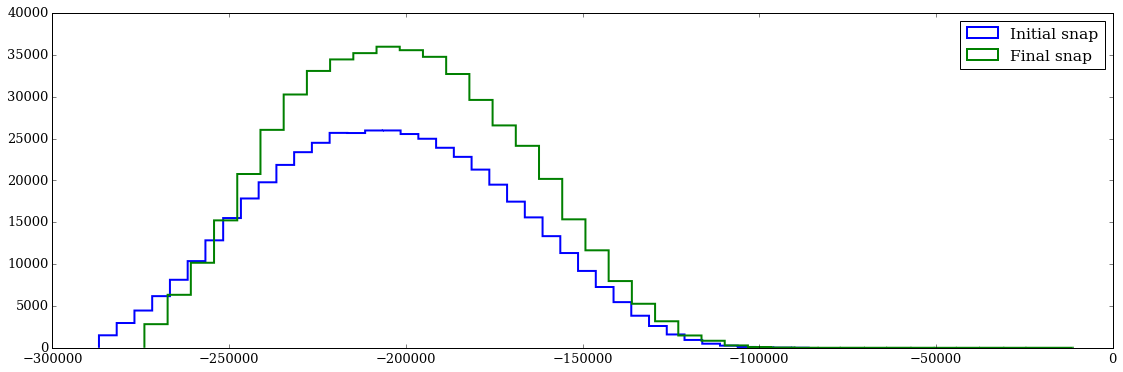

In [86]:
h = hist(I_diskP, bins=40, histtype='step', lw=2, label='Initial snap')
h = hist(F_diskP, bins=40, histtype='step', lw=2, label='Final snap')
legend()

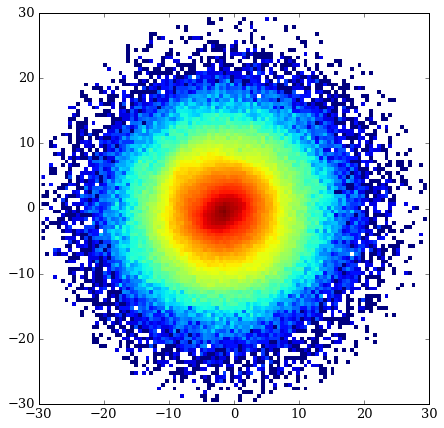

In [145]:
figure(figsize=(7, 7))
#subplot(1, 2, 1)
index_cut = np.where(np.sqrt(F_disk[:,0]**2.0 + F_disk[:,1]**2.0 + F_disk[:,2]**2.0) < 30)[0]
HR = hist2d(F_disk[index_cut,0], F_disk[index_cut,1], bins=100, norm=mpl.colors.LogNorm())
xlim(-20, 20)
ylim(-20, 20)
#colorbar()

axis('equal')

#subplot(1, 2, 2)
#MR = hist2d(F_disk[:,0], F_disk[:,1], bins=100, norm=mpl.colors.LogNorm())
#xlim(-20, 20)
#ylim(-20, 20)
#colorbar()

savefig('evolved_disk.pdf', bbox_inches='tight')


In [133]:
def CM_correction(x, y, z, pot):
    CM = np.where(pot == min(pot))[0]
    xc = x - x[CM]
    yc = y - y[CM]
    zc = z - z[CM]
    print x[CM], y[CM], z[CM]
    return xc, yc, zc

def VCM_correction(x, y, z, vx, vy, vz):
    center = np.where((x**2+y**2+z**2)<4.0)[0]
    N = len(center)
    vxcm = sum(vx[center])/N
    vycm = sum(vy[center])/N
    vzcm = sum(vz[center])/N
    print vxcm, vycm, vzcm
    vxc = vx - vxcm
    vyc = vy - vycm
    vzc = vz - vzcm
    return vxc, vyc, vzc

def rot_curve1(x, y, z, vx, vy, vz):
    R = np.linspace(0.1, 30, 30)
    vc = np.zeros(30)
    for i in range(len(R)-1):
        bin_cut = np.where((np.sqrt(x**2.0 + y**2.0) < R[i+1]) & (np.sqrt(x**2.0 + y**2.0) > R[i]) & (z<0.2) & (z>-0.2))[0]
        vc[i] = average(np.sqrt(vx[bin_cut]**2 + vy[bin_cut]**2 + vz[bin_cut]**2.0))
    return R, vc


def rot_curve2(x, y, z, vx, vy, vz):
    R = np.linspace(0, 30, 30)
    vc = np.zeros(30)
    for i in range(len(R)-1):
        bin_cut = np.where((x < R[i+1]) & ((x) > R[i]) & (z<0.5) & (z>-0.5))[0]
        vc[i] = average(np.sqrt(vx[bin_cut]**2 + vy[bin_cut]**2))
    return R, vc

def rot_curve3(x, y, z):
    R = np.linspace(0.1, 30, 80)
    G = constants.G
    G = G.to(u.km**3/u.s**2/u.Msun)
    mp = 1.044225e+39 * u.gram / 0.7
    mp = mp.to(u.Msun)
    conv = 1.0 * u.kpc
    conv = conv.to(u.km)
    EM = np.zeros(80)
    for i in range(len(R)):
        ER = np.where(np.sqrt(x**2+y**2)<R[i])
        TM = len(x[ER]) * mp.value
        EM[i] = np.sqrt(G.value * TM / (R[i] * conv.value) )
    return R, EM

In [134]:
I_Xc, I_Yc, I_Zc = CM_correction(I_disk[:,0], I_disk[:,1], I_disk[:,2], I_diskP)
F_Xc, F_Yc, F_Zc = CM_correction(F_disk[:,0], F_disk[:,1], F_disk[:,2], F_diskP)

I_Vxc, I_Vyc, I_Vzc = VCM_correction(I_Xc, I_Yc, I_Zc, I_diskV[:,0], I_diskV[:,1], I_diskV[:,2])
F_Vxc, F_Vyc, F_Vzc = VCM_correction(F_Xc, F_Yc, F_Zc, F_diskV[:,0], F_diskV[:,1], F_diskV[:,2])

[ 0.00254] [ 0.03600619] [ 0.03871866]
[-1.6174444] [-0.60472023] [-1.97362757]
-1.85156594466 -0.913364899798 -0.00712399499818
-0.0167325154838 1.03364988448 -1.50078607983


In [135]:
rot_curve_d = loadtxt('../data/ICs/MW/paul/rotcurve2.txt', skiprows=1)
r = rot_curve_d[:,0]
vcd = rot_curve_d[:,3]

In [136]:
def halo_correction(Mhalo, ahalo, Mbulge, cbulge, v_d, R_d):
    vc_h = vc_hernquist(ahalo, 0, R_d, 0, Mhalo)
    vc_b = vc_hernquist(cbulge, 0, R_d, 0, Mbulge)
    return np.sqrt(v_d**2.0 - vc_h**2.0 - vc_b**2.0)

In [137]:
RI, VI = rot_curve1(I_Xc, I_Yc, I_Zc, I_Vxc, I_Vyc, I_Vzc)
RF, VF = rot_curve1(F_Xc, F_Yc, F_Zc, F_Vxc, F_Vyc, I_Vzc)

Rd = np.linspace(0.1, 30, 30)
VDI = halo_correction(M_halo, A_halo, M_B2, A_B, VI, Rd)
VDF = halo_correction(M_halo, A_halo, M_B2, A_B, VF, Rd)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in sqrt


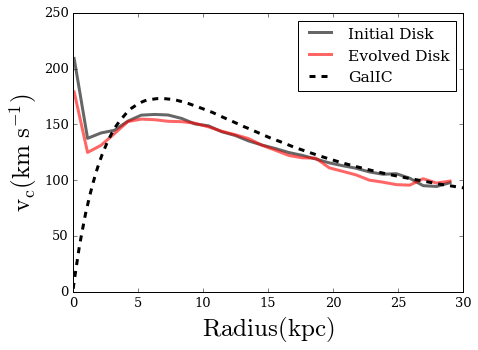

In [143]:
figure(figsize(7, 5))
plot(RI[:-1], VDI[:-1], c='k', alpha=0.6, label='Initial Disk', lw=3)
plot(RF[:-1], VDF[:-1], c='r', alpha=0.6, label='Evolved Disk', lw=3)
plot(r, vcd, lw=3, c='k', ls='--', label='GalIC')

legend(loc='lower center')
xlim(0, 30)
xlabel('$\mathrm{Radius(kpc)}$', fontsize=25)
ylabel('$\mathrm{v_c(km\ s^{-1}})$', fontsize=25)
legend()
savefig('Disk_rotcurve.pdf')

In [221]:
def exponential_rc(x, y, r_d, M):
    M = M*u.Msun
    r_d = r_d * u.kpc
    r = np.sqrt(x**2.0 + y**2.0)*u.kpc
    y = r/(2*r_d)
    Sigma = M/(2.0*np.pi*r_d**2)
    G = constants.G
    G = G.to(u.kpc**3/u.s**2/u.Msun)
    # Mod. Bessel functions.
    I0 = iv(0, y.value)
    I1 = iv(1, y.value)
    K0 = kv(0, y.value)
    K1 = kv(1, y.value)
    vc2 = 4.0*np.pi*G*Sigma*r_d*y**2.0*(I0*K0-I1*K1)
    vc = np.sqrt(vc2)    
    vc = vc.to(u.km/u.s)
    return vc

In [219]:
vce = exponential_rc(I_Xc, I_Yc, 3.1, 6.9E10)
#vcf = exponential_rc(F_Xc, F_Yc, 2.5)

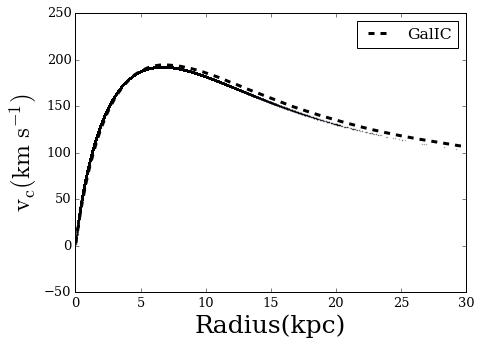

In [220]:
scatter(np.sqrt(I_Xc**2 + I_Yc**2), vce, alpha=0.5, s=0.1)
#scatter(np.sqrt(F_Xc**2 + F_Yc**2), vcf, alpha=0.5, s=0.1)

plot(r, vcd, lw=3, c='k', ls='--', label='GalIC')
xlim(0, 30)
legend()
xlabel('Radius(kpc)', fontsize=25)
ylabel('$\mathrm{v_c(km\ s^{-1}})$', fontsize=25)
savefig('Disk_rc.png')
